## Rose Tovar
### RoseATovar@gmail.com
### Heart Failure Prediection Project

In [43]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np

## Heart Failure Dataset

In [44]:
heart_df = pd.read_csv('heart.csv')

In [45]:
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Source
https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

### Description
> The dataset looks like different medical asepcts that may infleunce heart failure for isntance RestingBP, Cholesterol, Chest Pain Type, Resting ECG. And list if the individual has had heart Disease

### Target and Type of Problem
> The target being looked at in this problem is Heart Disease making this a classficiation problem

### Number of features and Rows

In [46]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


> We have 12 Columns and 918 Rows

### Checking for Duplicated Data and Removing Unessary Columns

In [47]:
heart_df.duplicated().sum()

0

In [48]:
# No rows are duplicated
# And we do not need to remove any columns

### Checking for missing values

In [49]:
# We have no missing values
heart_df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Inconsistencies Check in Categorial Data

In [50]:
# looking at object columns to see if any spelling errors
dtypes = heart_df.dtypes
str_cols = dtypes[dtypes=='object'].index
str_cols
for col in str_cols:
  print(f"- Column = {col}")
  print(heart_df[col].value_counts(dropna=False))
  print('\n\n')

- Column = Sex
M    725
F    193
Name: Sex, dtype: int64



- Column = ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64



- Column = RestingECG
Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64



- Column = ExerciseAngina
N    547
Y    371
Name: ExerciseAngina, dtype: int64



- Column = ST_Slope
Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64





In [51]:
# Looking at the cateoorical data we can see there are no Inconsistencies

### Reviewing Data Statistics Initial Look for Out of place data

In [52]:
heart_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [53]:
heart_df.loc[heart_df['Cholesterol'] == 603]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
149,54,M,ASY,130,603,1,Normal,125,Y,1.0,Flat,1


In [54]:
# WE do have an outlier with Cholesterol with it being 603. May need to talk to a subject specialist
# to find out if that is even possible. 

In [55]:
heart_df.loc[heart_df['Oldpeak'] == 6.2]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
850,62,F,ASY,160,164,0,LVH,145,N,6.2,Down,1


In [56]:
# 6.2 seems to be a high oldpeak and is an outlier in that column

In [57]:
heart_df.loc[heart_df['RestingBP'] == 0]
# it looks like for this perons they did not get the cholestorol Resting BP or Fasting BS.
# Because of this lack of information i will remove this row


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [58]:
heart_df.drop(449, inplace=True)

heart_df.loc[heart_df['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


In [59]:
heart_df.loc[heart_df['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [60]:
# We have a large amount of users with a cholesterol of zero we have we will make that na
# And impute that value with the mean of the column to maintain the average cholesterol

In [61]:
heart_df['Cholesterol'] = heart_df['Cholesterol'].replace(0, np.nan)

heart_df.isna().sum()

# 171 will be used in preprocessing and supply the average cholestorol for those mmissing values

Age                 0
Sex                 0
ChestPainType       0
RestingBP           0
Cholesterol       171
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

### Univariate Visualizations

In [62]:
# Setting up Default Settings for plots
sns.set_context('talk')
plt.style.use(['bmh', 'seaborn'])
plt.rcParams['font.family'] = 'serif'

#### Categorical Count Plots

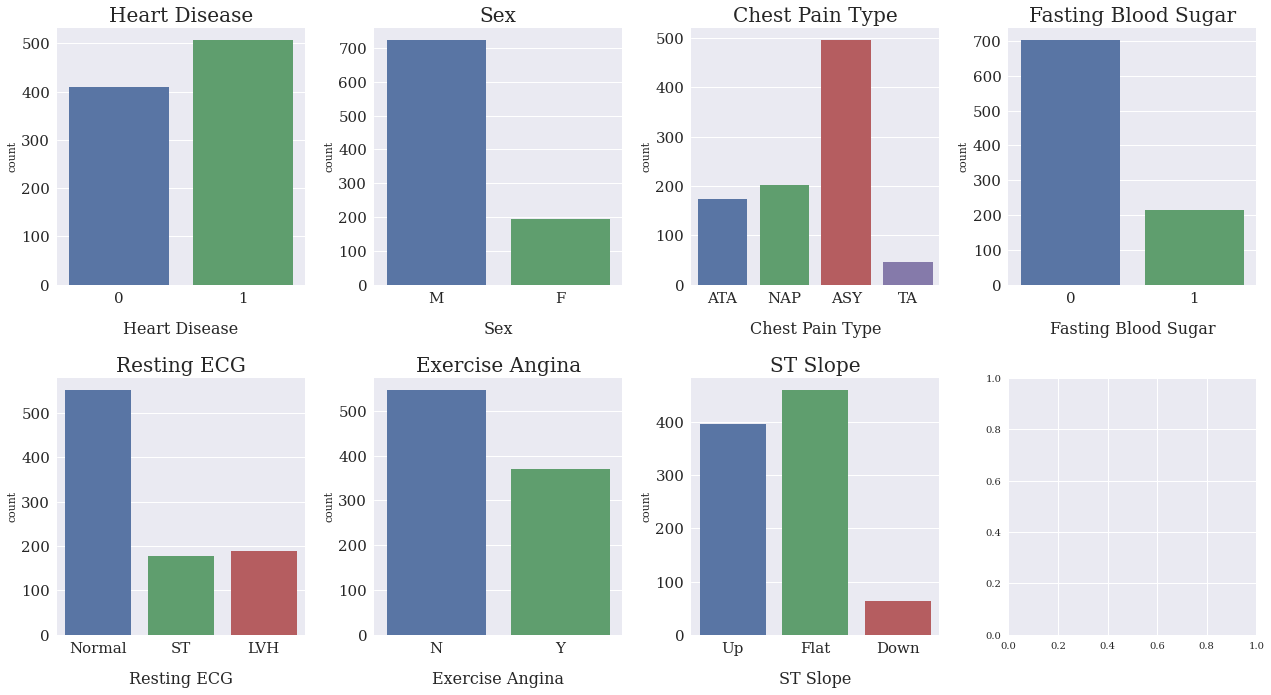

In [63]:
fig, axes = plt.subplots(2,4, figsize=(18,10))

axes = axes.ravel()
cols = ['HeartDisease', 'Sex', 'ChestPainType','FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
titles = ['Heart Disease', 'Sex', 'Chest Pain Type', "Fasting Blood Sugar", 'Resting ECG', "Exercise Angina", 'ST Slope']

for i, col in enumerate(cols):
    sns.countplot(data=heart_df, x=col, ax=axes[i])
    axes[i].set_title(f"{titles[i]}",fontsize='20')
    axes[i].tick_params(axis = 'both', which = 'major', labelsize = 15)
    axes[i].set_xlabel(titles[i], fontsize=16, labelpad=15)

plt.tight_layout()

##### Important Take ways from Categorical Data Exploration
* Slight Imbalance in data with more indviduals with Heart disease than not
* There are signficantly more men than women in this dataset
* ASY Chestpain has more instances, while ATA and NAP are close to each other, and TA is the least
* Many have a fasting blood sugar of 0
* Resting ECG is normal for many of the indidvduals in the dataset, ST and LVH are very close to one another
* Over 500 rows have no excercise Angina and around 370 have Excercise Angina
* An ST Slope of Flat is the most common followed by up. Down as the least amount in the dataset

#### Hist plots for Numerical Columns

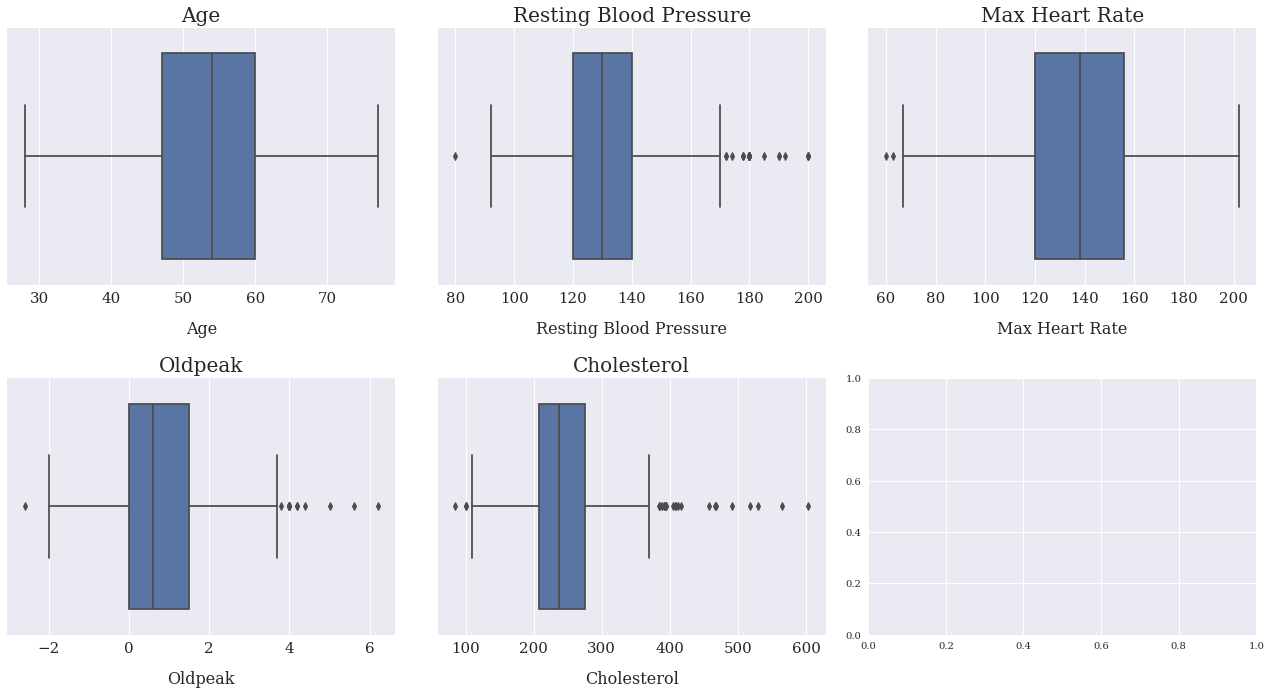

In [64]:
fig, axes = plt.subplots(2,3, figsize=(18,10))

axes = axes.ravel()
cols = ['Age', 'RestingBP', 'MaxHR', 'Oldpeak', 'Cholesterol']
titles = ['Age', "Resting Blood Pressure", "Max Heart Rate", "Oldpeak", "Cholesterol"]

for i, col in enumerate(cols):
    sns.boxplot(data=heart_df, x=col, ax=axes[i])
    axes[i].set_title(f"{titles[i]}",fontsize='20')
    axes[i].tick_params(axis = 'both', which = 'major', labelsize = 15)
    axes[i].set_xlabel(titles[i], fontsize=16, labelpad=15)

plt.tight_layout()

# most individuals in thsi dataset fall between 50 and 70

##### Outliers In the Dataset

* Age has no outliers, The ages go between around 30 to 70 years old
* With resting Blood pressure we have 9 Outliers, 1 is around 80, and the other 8 have a resting blood pressure above 170
* Max Heart Rate has 2 outliers, The 2 rows have a heart rate around 60
* Oldpeak has 8 outliers, One is goes below -2, the other 7 go from around 4 to just over 6
* Cholesterol runs between 100 and just under 400. We have 2 outliers with a cholesterol below 100, and the rest range from aroudn 370 to just over 600

### Exploring Correlations

<AxesSubplot:title={'center':'Heatmap Correlations'}>

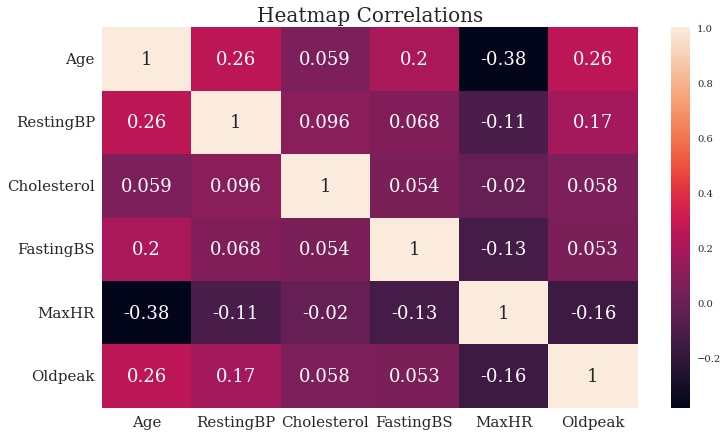

In [65]:
# creating heat  map for correlations
# WE are droppping heart disease from the heatmap bc that is a categorical column
corr = heart_df.drop(columns='HeartDisease').corr()
fig, ax = plt.subplots(figsize=(12,7))
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.set_title("Heatmap Correlations", fontsize='20')
sns.heatmap(data=corr, annot=True, ax=ax)

> Looking at the correlations we can see that there are a few correlations in the dataset. We can see that we have a low negative correlation between Max heart rate and age

### Multivariate Plots

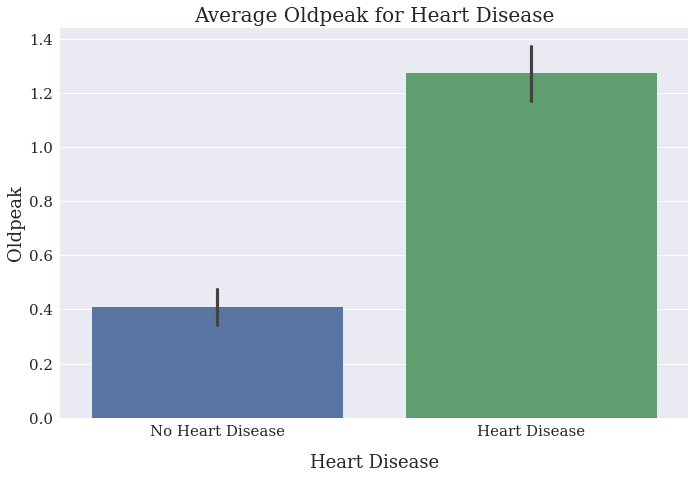

In [66]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=heart_df, x='HeartDisease', y='Oldpeak', ax=ax)
ax.set_xlabel("Heart Disease", fontsize=18,labelpad=15)
ax.set_xticklabels(['No Heart Disease', "Heart Disease"])
ax.set_ylabel("Oldpeak", fontsize=18)
ax.set_title('Average Oldpeak for Heart Disease', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.tight_layout()

> To understand this graph we first must understand what Oldpeak is. Oldpeak is the depressino of the ST Segment on an EKG. This shows us that indiviudals with heart disease have on average a olpeak of around 1.2. While those wtihout oldpeak have an oldpeak around 0.4. This tells us that oldpeak is can be explored as prominent feature in predicting heart disease in some indivudals.

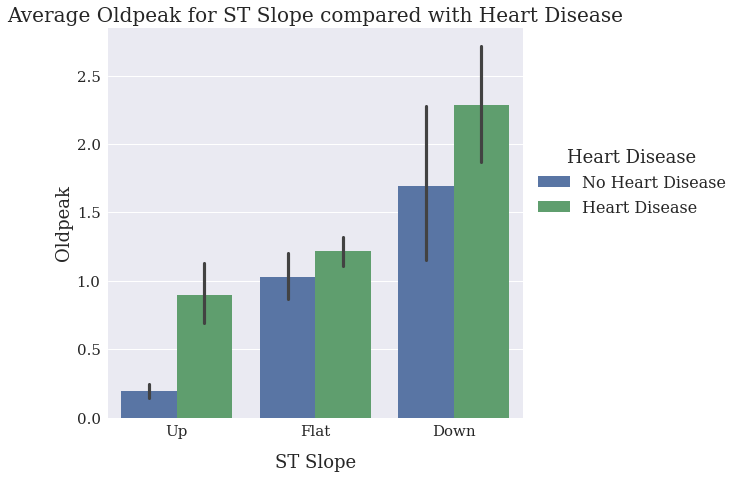

In [81]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=heart_df, x='ST_Slope', y='Oldpeak', hue='HeartDisease', ax=ax)
ax.set_xlabel("ST Slope", fontsize=18,labelpad=15)
ax.set_ylabel("Oldpeak", fontsize=18)
ax.set_title('Average Oldpeak for ST Slope compared with Heart Disease', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
L = ax.legend(loc=(1.02, .5), fontsize=16, title="Heart Disease")
L.get_texts()[0].set_text('No Heart Disease')
L.get_texts()[1].set_text('Heart Disease')
plt.tight_layout()

> This plot futher explores oldpeak; which is the depression of the ST Segment on an EKG. This time we evaluated the the average Oldpeak based on the type of ST Segment the indidvual has. A lower Oldpeak is seen for those without heart disease. But when it comees to the ST Slope down, there is a huge confidence interval with the oldpeak for that slope type. This could be a side effect of the outliers in the dataset that have a very large oldpeak. 